# This notebook analyzes the Mac sample against galaxies with the same LRG cuts from Petrillo and SDSS.
(i) The low-z (z < 0.4) LRG colour-magnitude selection of
Eisenstein et al. (2001), adapted to including more sources
(fainter and bluer):
r < 20
|c perp | < 0.2
r < 14 + c par /0.3
where
(1)
c par = 0.7(g − r) + 1.2[(r − i) − 0.18)]
c perp = (r − i) − (g − r)/4.0 − 0.18

(ii) A source size in the r -band larger than the average
FWHM of the PSF of the respective tiles, times a empir-
ical factor to maximize the separation between stars and galaxies.
# Edit 06/06/20 - Same mistake made with LRG cuts. 
# Edit 08/12/20 - Creating histogram of redshifts to see if the redshift bias is indeed toward low redshift.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#from numpy.polynomial.polynomial import polyfit
import pandas as pd
#from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
#from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM
from scipy import stats as sci

In [30]:
# create datapaths for files and figures
fits_path = '/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/'
csv_path = '/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/'
png_path = '/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/'
pdf_path = '/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/Final_PDFs_for_Paper/lambdar_revisions/'

In [31]:
### Samples 02/15/20
#spec = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/spec_candidates_021320.csv')
mac = pd.read_csv(f'{csv_path}mac_lambdar_revisions_063020.csv')
#zoo_121519 = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_021320.csv.csv')

## Load in Lambdar masses to combine M* and z

In [32]:
# Opening GAMA MagPhys data from G09, G12, and G15 (DR3)
hdul = fits.open(f'{fits_path}StellarMassesLambdar.fits')  # open a FITS file
hdul.verify('fix')
lambdar_data = hdul[1].data  # assume the first extension is a table
#print(gama_data.columns)

# take ID and templates/z from first and second fit
GAMA_ID = lambdar_data.CATAID.byteswap().newbyteorder()
lambdar_log_mstar = lambdar_data.logmintsfh.byteswap().newbyteorder()
lambdar_z = lambdar_data.Z.byteswap().newbyteorder()


lambdar_masses = pd.DataFrame(
    {'GAMA_ID' : GAMA_ID,
     'lambdar_log_mstar' : lambdar_log_mstar,
    'z' : lambdar_z}
) 
#     'logmremnants' : logmremnants, 
#     'fluxscale' : fluxscale})
lambdar_masses.GAMA_ID = lambdar_masses.GAMA_ID.astype(int)
lambdar_masses

,GAMA_ID,lambdar_log_mstar,z
0,6802,9.295552,0.05054
1,6806,11.251878,0.33124
2,6808,11.069718,0.22936
3,6810,11.397855,0.32630
4,6813,11.291913,0.48457
...,...,...,...
120614,4341320,10.162766,0.22847
120615,4342359,11.015234,0.64610
120616,4345978,11.303544,0.61111
120617,4347483,11.363264,0.59604


## g-band magnitude (AB)

In [33]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSg.fits')  # open a FITS file
hdul.verify('fix')
photo_g_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_g_id = photo_g_data.LAMID
# LAMID is GAMA ID where applicable.
photo_g_mag = photo_g_data.ABMagDFA

photo_g_list = list(zip(photo_g_id, photo_g_mag))

photo_g = pd.DataFrame(photo_g_list, columns = ['GAMA_ID', 'g'])
photo_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220158 entries, 0 to 220157
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   GAMA_ID  220158 non-null  object 
 1   g        220158 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.4+ MB


In [34]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
#photo_g['GAMA_ID'] = photo_g['GAMA_ID'].str.decode("utf-8")

In [35]:
# Remove IDs which have "New" in the name
photo_g = photo_g[~photo_g.GAMA_ID.str.contains('New')]
photo_g

,GAMA_ID,g
0,100000,20.594820
1,100001,20.743700
2,100002,18.867937
3,100003,20.013288
4,100004,19.506737
...,...,...
219453,99995,21.020639
219454,99996,21.404068
219455,99997,21.347977
219456,99998,20.773315


In [36]:
# Write IDs as integers
photo_g['GAMA_ID'] = photo_g.GAMA_ID.astype(int)

In [37]:
photo_g

,GAMA_ID,g
0,100000,20.594820
1,100001,20.743700
2,100002,18.867937
3,100003,20.013288
4,100004,19.506737
...,...,...
219453,99995,21.020639
219454,99996,21.404068
219455,99997,21.347977
219456,99998,20.773315


## r-band

In [38]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSr.fits')  # open a FITS file
hdul.verify('fix')
photo_r_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_r_id = photo_r_data.LAMID
# LAMID is GAMA ID where applicable.
photo_r_mag = photo_r_data.ABMagDFA

photo_r_list = list(zip(photo_r_id, photo_r_mag))

photo_r = pd.DataFrame(photo_r_list, columns = ['GAMA_ID', 'r'])
photo_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220158 entries, 0 to 220157
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   GAMA_ID  220158 non-null  object 
 1   r        220158 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.4+ MB


In [39]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
#photo_r['GAMA_ID'] = photo_r['GAMA_ID'].str.decode("utf-8")

In [40]:
# Remove IDs which have "New" in the name
photo_r = photo_r[~photo_r.GAMA_ID.str.contains('New')]
photo_r

,GAMA_ID,r
0,100000,19.811590
1,100001,19.662579
2,100002,17.846043
3,100003,19.200987
4,100004,19.207859
...,...,...
219453,99995,19.435972
219454,99996,19.633066
219455,99997,19.507254
219456,99998,19.538841


In [41]:
# Write IDs as integers
photo_r['GAMA_ID'] = photo_r.GAMA_ID.astype(int)

In [42]:
photo_r

,GAMA_ID,r
0,100000,19.811590
1,100001,19.662579
2,100002,17.846043
3,100003,19.200987
4,100004,19.207859
...,...,...
219453,99995,19.435972
219454,99996,19.633066
219455,99997,19.507254
219456,99998,19.538841


## i-band

In [43]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSi.fits')  # open a FITS file
hdul.verify('fix')
photo_i_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_i_id = photo_i_data.LAMID
# LAMID is GAMA ID where applicable.
photo_i_mag = photo_i_data.ABMagDFA

photo_i_list = list(zip(photo_i_id, photo_i_mag))

photo_i = pd.DataFrame(photo_i_list, columns = ['GAMA_ID', 'i'])
photo_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220158 entries, 0 to 220157
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   GAMA_ID  220158 non-null  object 
 1   i        220158 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.4+ MB


In [44]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
#photo_i['GAMA_ID'] = photo_i['GAMA_ID'].str.decode("utf-8")

In [45]:
# Remove IDs which have "New" in the name
photo_i = photo_i[~photo_i.GAMA_ID.str.contains('New')]
photo_i

,GAMA_ID,i
0,100000,19.469633
1,100001,19.226625
2,100002,17.358280
3,100003,18.706486
4,100004,18.875196
...,...,...
219453,99995,18.752949
219454,99996,18.998640
219455,99997,18.886461
219456,99998,19.030018


In [46]:
# Write IDs as integers
photo_i['GAMA_ID'] = photo_i.GAMA_ID.astype(int)
photo_i

,GAMA_ID,i
0,100000,19.469633
1,100001,19.226625
2,100002,17.358280
3,100003,18.706486
4,100004,18.875196
...,...,...
219453,99995,18.752949
219454,99996,18.998640
219455,99997,18.886461
219456,99998,19.030018


## Now I create variables to establish criteria for satisfying Petrillo's LRG classification.

In [47]:
# create variables for the criteria
# join all photometry measurements to GAMA_ID
gr = pd.merge(photo_g, photo_r, on = 'GAMA_ID')
gri = pd.merge(gr, photo_i, on = 'GAMA_ID')

# convert to Johnson magnitude system (or # out addition for AB)
# We want AB.
g = gri.g# + 0.013
r = gri.r# + 0.226
i = gri.i# + 0.296

c_par = 0.7*(g - r) + 1.2*((r - i) - 0.18)
c_perp = (r - i) - (g - r)/4.0 - 0.18

gri['c_par'] = c_par
gri['c_perp'] = c_perp

gri
# what was I thinking with this stuff? I must have copied and pasted it. Bad.
# add columns c_par and c_perp to magphys
#magphys['r'] = r
#magphys['c_par'] = c_par
#magphys['c_perp'] = c_perp

#magphys

,GAMA_ID,g,r,i,c_par,c_perp
0,100000,20.594820,19.811590,19.469633,0.742609,-0.033850
1,100001,20.743700,19.662579,19.226625,1.063929,-0.014327
2,100002,18.867937,17.846043,17.358280,1.084641,0.052289
3,100003,20.013288,19.200987,18.706486,0.946012,0.111426
4,100004,19.506737,19.207859,18.875196,0.392410,0.077943
...,...,...,...,...,...,...
219453,99995,21.020639,19.435972,18.752949,1.712895,0.106857
219454,99996,21.404068,19.633066,18.998640,1.785013,0.011676
219455,99997,21.347977,19.507254,18.886461,1.817457,-0.019388
219456,99998,20.773315,19.538841,19.030018,1.258720,0.020205


In [48]:
# merge with magphys
lambdar_catalog = pd.merge(lambdar_masses, gri, on = 'GAMA_ID')
lambdar_catalog.columns

Index(['GAMA_ID', 'lambdar_log_mstar', 'z', 'g', 'r', 'i', 'c_par', 'c_perp'], dtype='object')

## Update 3/20/20: I neglected to include an additional cut imposed by Petrillo. The above is for z < 0.4. For all redshifts, they took only those targets whose r-band size (angular diameter) is larger than the PSF.

In [49]:
# load in Sersic photometric data to get effective radii
# Columns GALRE_r and GALRE_i are effective radii in r and i bands
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/SersicCatSDSS.fits')  # open a FITS file
photometry = hdul[1].data  # assume the first extension is a table
#print(hdul[1].columns)

Reff_GAMA_ID = photometry['CATAID']
#Reff_i = photometry['GALRE_i']
Reff_r = photometry['GALRE_r']

Reff_data = list(zip(Reff_GAMA_ID, Reff_r))#, Reff_i))
Reff = pd.DataFrame(Reff_data, columns = ['GAMA_ID',
                                                    'Reff_r'])
                                                    #'Reff_i'])

Reff
#print(zoo_data.columns)

,GAMA_ID,Reff_r
0,6802,1.107750
1,6803,0.535145
2,6804,0.795294
3,6805,0.448633
4,6806,1.690017
...,...,...
221368,4345061,-3389.660889
221369,4345978,0.855806
221370,4347483,1.070087
221371,4348349,0.538027


In [50]:
gama = pd.merge(lambdar_catalog, Reff, on = 'GAMA_ID')
# take sources whose angular diameter is > 0.65 and remove crazy data (Reff_r > 100)
# edit (07/18/20) - take five different parent samples to account for unknown
# "empirical factor" used by Petrillo to scale PSF... 1, 1.5, 2.0, 2.5, 3.0
gama_LRG_1 = gama[(gama.Reff_r > 0.65) & (gama.r < 20) & (gama.z < 2) & (gama.z > 0.01)] #& (gama.Z > 0.4) & (gama.Z < 0.5)]
gama_LRG_15 = gama[(gama.Reff_r > 1.5*0.65) & (gama.r < 20) & (gama.z < 2) & (gama.z > 0.01)] 
gama_LRG_2 = gama[(gama.Reff_r > 2.0*0.65) & (gama.r < 20) & (gama.z < 2) & (gama.z > 0.01)] 
gama_LRG_25 = gama[(gama.Reff_r > 2.5*0.65) & (gama.r < 20) & (gama.z < 2) & (gama.z > 0.01)] 
gama_LRG_3 = gama[(gama.Reff_r > 3.0*0.65) & (gama.r < 20) & (gama.z < 2) & (gama.z > 0.01)] 

print(len(gama_LRG_1),
      len(gama_LRG_15),
      len(gama_LRG_2),
      len(gama_LRG_25),
      len(gama_LRG_3))

108051 93025 73344 54893 40562


In [51]:
# Concatanate two datasets into one LRG sample.
#gama_LRG = pd.merge([gama_LRG_1,gama_LRG_2])

# instead, we will run the z < 4 LRG cuts on this catalog.
#gama_LRG.columns

In [52]:
gama_LRG_1_low = gama_LRG_1[gama_LRG_1.z <= 0.4]
gama_LRG_1_hi = gama_LRG_1[gama_LRG_1.z > 0.4]

gama_LRG_15_low = gama_LRG_15[gama_LRG_15.z <= 0.4]
gama_LRG_15_hi = gama_LRG_15[gama_LRG_15.z > 0.4]

gama_LRG_2_low = gama_LRG_2[gama_LRG_2.z <= 0.4]
gama_LRG_2_hi = gama_LRG_2[gama_LRG_2.z > 0.4]

gama_LRG_25_low = gama_LRG_25[gama_LRG_25.z <= 0.4]
gama_LRG_25_hi = gama_LRG_25[gama_LRG_25.z > 0.4]

gama_LRG_3_low = gama_LRG_3[gama_LRG_3.z <= 0.4]
gama_LRG_3_hi = gama_LRG_3[gama_LRG_3.z > 0.4]

#print(len(gama_LRG_low),
#      len(gama_LRG_hi))


In [53]:
# Take Petrillo's 1st set of criteria for LRG (z < 0.4)
gama_LRG_1_low = gama_LRG_1_low[(abs(gama_LRG_1_low.c_perp) < 0.2) & (gama_LRG_1_low.r < 14 + gama_LRG_1_low.c_par/0.3)]
gama_LRG_15_low = gama_LRG_15_low[(abs(gama_LRG_15_low.c_perp) < 0.2) & (gama_LRG_15_low.r < 14 + gama_LRG_15_low.c_par/0.3)]
gama_LRG_2_low = gama_LRG_2_low[(abs(gama_LRG_2_low.c_perp) < 0.2) & (gama_LRG_2_low.r < 14 + gama_LRG_2_low.c_par/0.3)]
gama_LRG_25_low = gama_LRG_25_low[(abs(gama_LRG_25_low.c_perp) < 0.2) & (gama_LRG_25_low.r < 14 + gama_LRG_25_low.c_par/0.3)]
gama_LRG_3_low = gama_LRG_3_low[(abs(gama_LRG_3_low.c_perp) < 0.2) & (gama_LRG_3_low.r < 14 + gama_LRG_3_low.c_par/0.3)]
#gama_LRG_1 = gama_LRG_1[abs(gama_LRG_1.r) < 20] # r band mag limit for kids
#gama_LRG_low
print(len(gama_LRG_1_low),
      len(gama_LRG_15_low),
      len(gama_LRG_2_low),
      len(gama_LRG_25_low),
      len(gama_LRG_3_low))

15781 14978 13064 10984 9257


In [54]:
#gama_LRG = pd.concat([gama_LRG_low, gama_LRG_hi])
gama_LRG_1 = pd.concat([gama_LRG_1_low, gama_LRG_1_hi])
gama_LRG_15 = pd.concat([gama_LRG_15_low, gama_LRG_15_hi])
gama_LRG_2 = pd.concat([gama_LRG_2_low, gama_LRG_2_hi])
gama_LRG_25 = pd.concat([gama_LRG_25_low, gama_LRG_25_hi])
gama_LRG_3 = pd.concat([gama_LRG_3_low, gama_LRG_3_hi])

print(len(gama_LRG_1),
      len(gama_LRG_15),
      len(gama_LRG_2),
      len(gama_LRG_25),
      len(gama_LRG_3))

20009 18646 15739 12761 10421


## Plot z to mass for both ML candidates and GAMA LRGs

NameError: name 'gama_LRG' is not defined

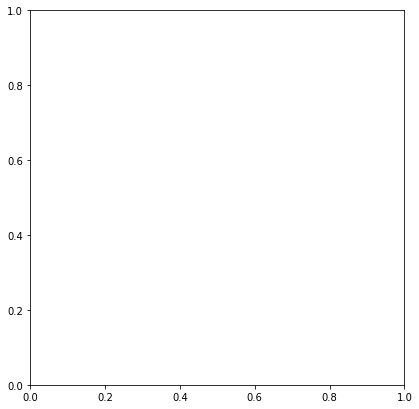

In [27]:
# Three-panel plot
from matplotlib.ticker import NullFormatter
nullfmt   = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.1, 0.65
lower, height = 0.1, 0.65
lower_h = left_h = left+width+0.02
    
rect_scatter = [left, lower, width, height]
#rect_histx = [left, lower_h, width, 0.2]
#rect_histy = [left_h, lower, 0.2, height]
    
    # start with a rectangular Figure
plt.figure(1, figsize=(8,8))
    
axScatter = plt.axes(rect_scatter)
#axHistx = plt.axes(rect_histx)
#axHisty = plt.axes(rect_histy)

binwidth = 0.5
bins=20

    # no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.plot(gama_LRG.lambdar_log_mstar, gama_LRG.z, 'co', alpha = 0.5)# fillstyle = 'none')
axScatter.plot(mac.lambdar_log_mstar, mac.z, 'go')

axScatter.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=20)
axScatter.set_ylabel(r'Redshift (z)', fontsize=20)

#axHisty.hist(spec.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHisty.hist(pg_sample.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='c', histtype = 'step', linewidth=3)

#axHistx.hist(np.log10(spec.STELLAR_MASS), range=[7,12], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHistx.hist(np.log10(pg_sample.STELLAR_MASS), range=[7,12], bins=bins,color='c', histtype = 'step', linewidth=3)
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/mac_gama_lrg_zmass.png')

# K-S Tests of z and M*

In [55]:
print(sci.ks_2samp(mac.z, gama_LRG_1.z))
print(sci.ks_2samp(mac.z, gama_LRG_15.z))
print(sci.ks_2samp(mac.z, gama_LRG_2.z))
print(sci.ks_2samp(mac.z, gama_LRG_25.z))
print(sci.ks_2samp(mac.z, gama_LRG_3.z))

Ks_2sampResult(statistic=0.24094689304706496, pvalue=0.008640694093364274)
Ks_2sampResult(statistic=0.2634402221912862, pvalue=0.002985103515031893)
Ks_2sampResult(statistic=0.31964506112340535, pvalue=0.0001387944395997853)
Ks_2sampResult(statistic=0.38707197961875195, pvalue=1.6109352961065847e-06)
Ks_2sampResult(statistic=0.44294560696792684, pvalue=2.1249704666737498e-08)


In [32]:
#sci.ks_2samp(mac.lambdar_mstar, 10**(gama_LRG.lambdar_log_mstar))
print(sci.ks_2samp(10**mac.lambdar_log_mstar, 10**gama_LRG_1.lambdar_log_mstar))
print(sci.ks_2samp(10**mac.lambdar_log_mstar, 10**gama_LRG_15.lambdar_log_mstar))
print(sci.ks_2samp(10**mac.lambdar_log_mstar, 10**gama_LRG_2.lambdar_log_mstar))
print(sci.ks_2samp(10**mac.lambdar_log_mstar, 10**gama_LRG_25.lambdar_log_mstar))
print(sci.ks_2samp(10**mac.lambdar_log_mstar, 10**gama_LRG_3.lambdar_log_mstar))

Ks_2sampResult(statistic=0.47048190016620184, pvalue=1.930870401024209e-09)
Ks_2sampResult(statistic=0.46003820339083623, pvalue=4.8197785993725505e-09)
Ks_2sampResult(statistic=0.43972217002621217, pvalue=2.6980164407788306e-08)
Ks_2sampResult(statistic=0.42252574749861194, pvalue=1.0954790042569372e-07)
Ks_2sampResult(statistic=0.41223225606232916, pvalue=2.481921528038481e-07)


# Edit 08/12/20 - Histograms

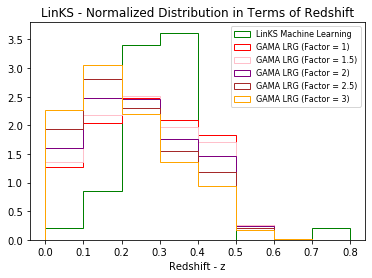

In [93]:
plt.hist(mac.z, 
         histtype='step',
         density=True,
        color='g',
         range=(0, 0.8),
        bins=8,
        label='LinKS Machine Learning')
plt.hist(gama_LRG_1.z,
        histtype='step',
         density=True,
        color='red',
        range=(0, 0.8),
        bins=8,
        label='GAMA LRG (Factor = 1)')
plt.hist(gama_LRG_15.z,
        histtype='step',
         density=True,
        color='pink',
        range=(0, 0.8),
        bins=8,
        label='GAMA LRG (Factor = 1.5)')
plt.hist(gama_LRG_2.z,
        histtype='step',
         density=True,
        color='purple',
        range=(0, 0.8),
        bins=8,
        label='GAMA LRG (Factor = 2)')
plt.hist(gama_LRG_25.z,
        histtype='step',
         density=True,
        color='brown',
        range=(0, 0.8),
        bins=8,
        label='GAMA LRG (Factor = 2.5)')
plt.hist(gama_LRG_3.z,
        histtype='step',
         density=True,
        color='orange',
        range=(0, 0.8),
        bins=8,
        label='GAMA LRG (Factor = 3)')
plt.legend(fontsize=8)
plt.xlabel('Redshift - z')
plt.title('LinKS - Normalized Distribution in Terms of Redshift')

#plt.savefig(f'{png_path}mac_ks_histogram_z.png')
#plt.savefig(f'{pdf_path}mac_ks_histogram_z.pdf')

/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


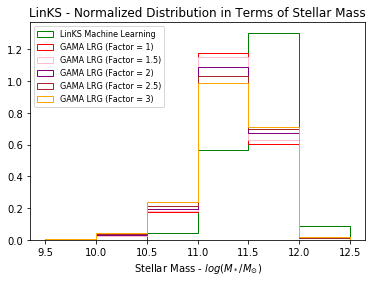

In [94]:
plt.hist(mac.lambdar_log_mstar, 
         histtype='step',
         density=True,
        color='g',
         range=(9.5, 12.5),
        bins=6,
        label='LinKS Machine Learning')
plt.hist(gama_LRG_1.lambdar_log_mstar,
        histtype='step',
         density=True,
        color='red',
        range=(9.5, 12.5),
        bins=6,
        label='GAMA LRG (Factor = 1)')
plt.hist(gama_LRG_15.lambdar_log_mstar,
        histtype='step',
         density=True,
        color='pink',
        range=(9.5, 12.5),
        bins=6,
        label='GAMA LRG (Factor = 1.5)')
plt.hist(gama_LRG_2.lambdar_log_mstar,
        histtype='step',
         density=True,
        color='purple',
        range=(9.5, 12.5),
        bins=6,
        label='GAMA LRG (Factor = 2)')
plt.hist(gama_LRG_25.lambdar_log_mstar,
        histtype='step',
         density=True,
        color='brown',
        range=(9.5, 12.5),
        bins=6,
        label='GAMA LRG (Factor = 2.5)')
plt.hist(gama_LRG_3.lambdar_log_mstar,
        histtype='step',
         density=True,
        color='orange',
        range=(9.5, 12.5),
        bins=6,
        label='GAMA LRG (Factor = 3)')
plt.legend(fontsize=8, 
           loc='upper left')
plt.xlabel('Stellar Mass - $log(M_*/M_{\odot})$')
plt.title('LinKS - Normalized Distribution in Terms of Stellar Mass')

#plt.savefig(f'{png_path}mac_ks_histogram_mass.png')
#plt.savefig(f'{pdf_path}mac_ks_histogram_mass.pdf')


# A-D tests of z and M*

In [ ]:
sci.anderson_ksamp([mac.Z,gama_LRG.Z])

In [ ]:
sci.anderson_ksamp([mac.STELLAR_MASS,gama_LRG.STELLAR_MASS])

## Now to see if Zoo passes the LRG cuts.

In [80]:
zoo = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_032020.csv')

In [89]:
# create variables for the criteria
# convert to Johnson magnitude system (or # out addition for AB)
g = photo_g.g# + 0.013
r = photo_r.r# + 0.226
i = photo_i.i# + 0.296

c_par = 0.7*(g - r) + 1.2*((r - i) - 0.18)
c_perp = (r - i) - (g - r)/4.0 - 0.18

# add columns c_par and c_perp to zoo
zoo['r'] = r
zoo['c_par'] = c_par
zoo['c_perp'] = c_perp

zoo

,Unnamed: 0,Unnamed: 0.1,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,r,c_par,c_perp
0,0,319,511867,216.38846,-1.11396,0.352229,5.459000e+10,0.0550,1.399744e+11,1.595680,19.811590,0.742609,-0.033850
1,2,487,485873,217.75015,-1.80042,0.349456,4.908000e+10,0.0539,1.258462e+11,1.528370,19.662579,1.063929,-0.014327
2,4,1264,70022,178.02218,0.07392,0.368109,8.046000e+10,0.0599,2.063077e+11,1.856296,17.846043,1.084641,0.052289
3,5,2065,170898,176.46563,-2.33643,0.336096,2.319000e+11,0.1215,5.946154e+11,2.212752,19.200987,0.946012,0.111426
4,6,2401,184275,175.91698,-1.44119,0.317262,4.411000e+10,0.1237,1.131026e+11,0.956432,19.207859,0.392410,0.077943
5,7,2485,84050,175.79849,0.47814,0.365758,5.471000e+10,0.1190,1.402821e+11,1.086001,17.286449,0.567910,-0.025030
6,8,2524,7104,175.71213,0.83228,0.333333,1.768000e+10,0.0751,4.533333e+10,0.777126,17.592030,0.579694,0.059571
7,10,4670,55245,181.07958,-0.31553,0.314054,1.274000e+11,0.0936,3.266667e+11,1.868604,19.783960,0.555440,-0.003715
8,11,5098,70282,179.40308,0.12562,0.655352,4.256000e+10,0.1074,1.091282e+11,1.008252,17.508411,1.120424,0.049256
9,12,5698,185451,180.28326,-1.61006,0.302985,8.222000e+10,0.1079,2.108205e+11,1.398133,19.131847,0.567161,-0.002700


In [91]:
# Take Petrillo's 1st set of criteria for LRG (z < 0.4)
zoo_LRG_1 = zoo[(zoo.Z < 0.4) & (zoo.r < 20) & (abs(zoo.c_perp)) & (zoo.r < 14 + zoo.c_par/0.3)]
zoo_LRG_1 = zoo_LRG_1[abs(zoo_LRG_1.r) < 100]
zoo_LRG_1

,Unnamed: 0,Unnamed: 0.1,GAMA_ID,RA,DEC,LENS_SCORE,STELLAR_MASS,Z,TOTAL_MASS,theta_e,r,c_par,c_perp
8,11,5098,70282,179.40308,0.12562,0.655352,4.256000e+10,0.1074,1.091282e+11,1.008252,17.508411,1.120424,0.049256
18,22,11076,136604,175.87349,-1.74167,0.316451,2.866000e+11,0.1060,7.348718e+11,2.633636,17.927132,1.226641,-0.015483
21,25,12397,324764,137.20387,1.72633,0.422757,4.647000e+10,0.1044,1.191538e+11,1.068579,17.401047,1.293173,-0.004201
24,28,13836,342699,216.90174,2.13250,0.457088,2.845000e+10,0.0876,7.294872e+10,0.912766,19.387873,1.940855,0.083289
27,32,15421,422113,129.41517,2.59516,0.499580,2.020000e+10,0.1202,5.179487e+10,0.656590,17.451962,1.418676,-0.045077
35,40,26107,238271,213.72842,1.57878,0.331694,7.078000e+10,0.1287,1.814872e+11,1.187781,18.607557,1.638089,-0.004892
